# Book Code

In [3]:
import os
import tarfile

tf = tarfile.open('hildegard.tar.gz', 'r')
tf.extractall('data')

In [4]:
from pathlib import Path

def load_directory(directory, max_length):
    documents, authors, titles = [], [], []
    directory = Path(directory)
    for filename in sorted(directory.iterdir()):
        if not filename.suffix == '.txt':
            continue
        author, title = filename.stem.split("_")

        with filename.open() as f:
            contents = f.read()
        lemmas = contents.lower().split()
        start_idx, end_idx, segm_cnt = 0, max_length, 1

        # extract slices from the text:
        while end_idx < len(lemmas):
            documents.append(' '.join(lemmas[start_idx:end_idx]))
            authors.append(author[0])
            titles.append(f"{title}-{segm_cnt}")

            start_idx += max_length
            end_idx += max_length
            segm_cnt += 1

    return documents, authors, titles

In [5]:
documents, authors, titles = load_directory('data/hildegard/texts', 10000)

In [6]:
import sklearn.feature_extraction.text as text

vectorizer = text.CountVectorizer(max_features=30, token_pattern=r"(?u)\b\w+\b")
v_documents = vectorizer.fit_transform(documents).toarray()

print(v_documents.shape)
print(vectorizer.get_feature_names_out()[:5])

(36, 30)
['a' 'ad' 'cum' 'de' 'deus']


In [7]:
vocab = [l.strip() for l in open('data/hildegard/wordlist.txt')
         if not l.startswith('#') and l.strip()][:65]

vectorizer = text.CountVectorizer(token_pattern=r"(?u)\b\w+\b", vocabulary=vocab)
v_documents = vectorizer.fit_transform(documents).toarray()

print(v_documents.shape)
print(vectorizer.get_feature_names_out()[:5])

(36, 65)
['et' 'qui' 'in' 'non' 'ad']


In [8]:
import sklearn.preprocessing as preprocessing

v_documents = preprocessing.normalize(v_documents.astype(float), norm='l1')

In [9]:
import numpy as np
import scipy.spatial.distance as scidist

scaler = preprocessing.StandardScaler()
s_documents = scaler.fit_transform(v_documents)

test_doc = s_documents[0]
distances = [
    scidist.cityblock(test_doc, train_doc) for train_doc in s_documents[1:]
]

print(authors[np.argmin(distances) + 1])

B


In [10]:
import sklearn.model_selection as model_selection

test_size = len(set(authors)) * 2
(train_documents, test_documents,
 train_authors, test_authors) = model_selection.train_test_split(
    v_documents, authors, test_size=test_size, stratify=authors, random_state=1)

print(f'N={test_documents.shape[0]} test documents with '
      f'V={test_documents.shape[1]} features.')

print(f'N={train_documents.shape[0]} train documents with '
      f'V={train_documents.shape[1]} features.')

N=6 test documents with V=65 features.
N=30 train documents with V=65 features.


In [11]:
scaler = preprocessing.StandardScaler()
scaler.fit(train_documents)

train_documents = scaler.transform(train_documents)
test_documents = scaler.transform(test_documents)

distances = scidist.cdist(test_documents, train_documents, metric='cityblock')

nn_predictions = np.array(train_authors)[np.argmin(distances, axis=1)]
print(nn_predictions[:3])

['G' 'H' 'B']


In [12]:
class Delta:
    """Delta-Based Authorship Attributer."""

    def fit(self, X, y):
        """Fit (or train) the attributer.

        Arguments:
            X: a two-dimensional array of size NxV, where N represents
               the number of training documents, and V represents the
               number of features used.
            y: a list (or NumPy array) consisting of the observed author
                for each document in X.

        Returns:
            Delta: A trained (fitted) instance of Delta.

        """
        self.train_y = np.array(y)
        self.scaler = preprocessing.StandardScaler(with_mean=False)
        self.train_X = self.scaler.fit_transform(X)

        return self

    def predict(self, X, metric='cityblock'):
        """Predict the authorship for each document in X.

        Arguments:
            X: a two-dimensional (sparse) matrix of size NxV, where N
               represents the number of test documents, and V represents
               the number of features used during the fitting stage of
               the attributer.
            metric (str, optional): the metric used for computing
               distances between documents. Defaults to 'cityblock'.

        Returns:
            ndarray: the predicted author for each document in X.

        """
        X = self.scaler.transform(X)
        dists = scidist.cdist(X, self.train_X, metric=metric)
        return self.train_y[np.argmin(dists, axis=1)]

In [13]:
import sklearn.metrics as metrics

delta = Delta()
delta.fit(train_documents, train_authors)
preds = delta.predict(test_documents)

for true, pred in zip(test_authors, preds):
    _connector = 'WHEREAS' if true != pred else 'and'
    print(f'Observed author is {true} {_connector} {pred} was predicted.')

accuracy = metrics.accuracy_score(preds, test_authors)
print(f"\nAccuracy of predictions: {accuracy:.1f}")

Observed author is G and G was predicted.
Observed author is H and H was predicted.
Observed author is B and B was predicted.
Observed author is B and B was predicted.
Observed author is B and B was predicted.
Observed author is G and G was predicted.

Accuracy of predictions: 1.0


In [14]:
with open('data/hildegard/texts/test/B_Mart.txt') as f:
    test_doc = f.read()

v_test_doc = vectorizer.transform([test_doc]).toarray()
v_test_doc = preprocessing.normalize(v_test_doc.astype(float), norm='l1')

print(delta.predict(v_test_doc)[0])

B


In [15]:
train_documents, train_authors, train_titles = load_directory('data/hildegard/texts', 3301)

vectorizer = text.CountVectorizer(token_pattern=r"(?u)\b\w+\b", vocabulary=vocab)
v_train_documents = vectorizer.fit_transform(train_documents).toarray()
v_train_documents = preprocessing.normalize(v_train_documents.astype(float), norm='l1')

delta = Delta().fit(v_train_documents, train_authors)

test_docs, test_authors, test_titles = load_directory('data/hildegard/texts/test', 3301)

v_test_docs = vectorizer.transform(test_docs).toarray()
v_test_docs = preprocessing.normalize(v_test_docs.astype(float), norm='l1')

In [16]:
predictions = delta.predict(v_test_docs)

for filename, prediction in zip(test_titles, predictions):
    print(f'{filename} -> {prediction}')

Mart-1 -> B
Mart-1 -> G
Missa-1 -> G
Missa-2 -> G


In [17]:
predictions = delta.predict(v_test_docs, metric='cosine')
for filename, prediction in zip(test_titles, predictions):
    print(f'{filename} -> {prediction}')

Mart-1 -> B
Mart-1 -> G
Missa-1 -> G
Missa-2 -> G


In [18]:
vectorizer = text.CountVectorizer(token_pattern=r"(?u)\b\w+\b", vocabulary=vocab)

v_documents = vectorizer.fit_transform(documents).toarray()
v_documents = preprocessing.normalize(v_documents.astype(np.float64), 'l1')
scaler = preprocessing.StandardScaler()
v_documents = scaler.fit_transform(v_documents)

print(f'N={v_documents.shape[0]} documents with '
      f'V={v_documents.shape[1]} features.')

N=36 documents with V=65 features.


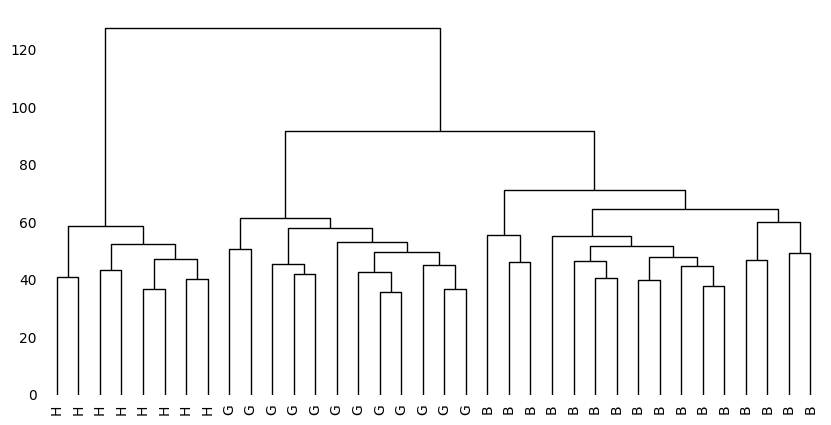

In [19]:
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hierarchy

# 1. Calculate pairwise distances
dm = scidist.pdist(v_documents, 'cityblock')

# 2. Establish branch structure
linkage_object = hierarchy.linkage(dm, method='complete')

# 3. Visualize
def plot_tree(linkage_object, labels, figsize=(10, 5), ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    with plt.rc_context({'lines.linewidth': 1.0}):
        hierarchy.dendrogram(
            linkage_object, labels=labels, ax=ax,
            link_color_func=lambda c: 'black',
            leaf_font_size=10, leaf_rotation=90)
    # Remove ticks and spines
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    for s in ax.spines.values():
        s.set_visible(False)

plot_tree(linkage_object, authors)

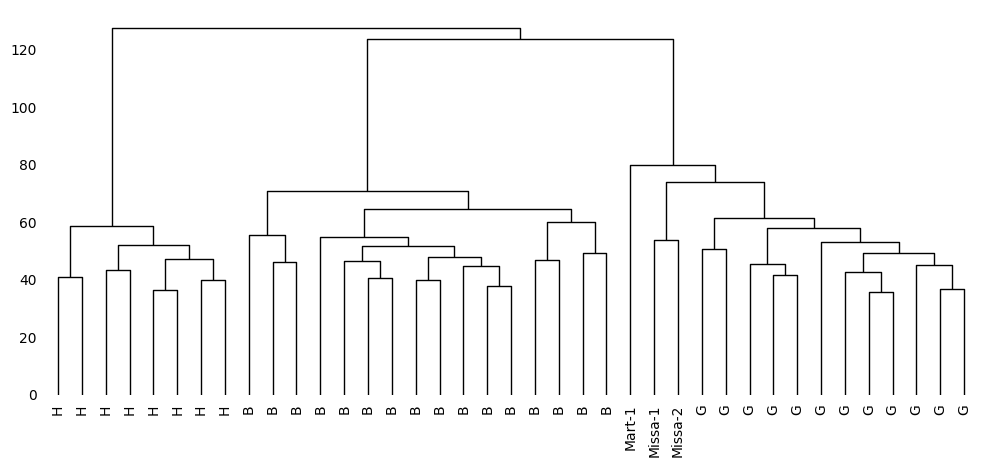

In [20]:
v_test_docs = vectorizer.transform(test_docs[1:])
v_test_docs = preprocessing.normalize(v_test_docs.astype(float), norm='l1')
v_test_docs = scaler.transform(v_test_docs.toarray())

all_documents = np.vstack((v_documents, v_test_docs))

dm = scidist.pdist(all_documents, 'cityblock')
linkage_object = hierarchy.linkage(dm, method='complete')

plot_tree(linkage_object, authors + test_titles[1:], figsize=(12, 5))

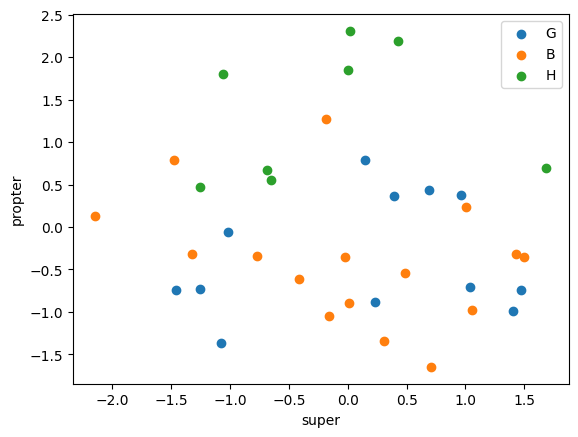

In [21]:
words = list(vectorizer.get_feature_names_out())
authors = np.array(authors)
x = v_documents[:, words.index('super')]
y = v_documents[:, words.index('propter')]

fig, ax = plt.subplots()
for author in set(authors):
    ax.scatter(x[authors==author], y[authors==author], label=author)
ax.set(xlabel='super', ylabel='propter')
plt.legend();

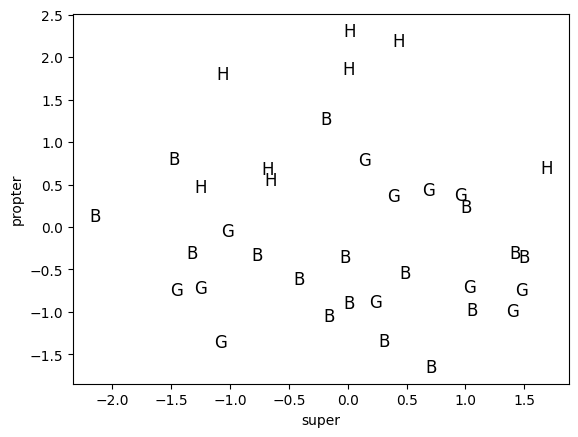

In [22]:
fig, ax = plt.subplots()
ax.scatter(x, y, facecolors='none')
for p1, p2, author in zip(x, y, authors):
    ax.text(p1, p2, author[0], fontsize=12,
            ha='center', va='center')
ax.set(xlabel='super', ylabel='propter');

In [23]:
import sklearn.decomposition

pca = sklearn.decomposition.PCA(n_components=2)
documents_proj = pca.fit_transform(v_documents)

print(v_documents.shape)
print(documents_proj.shape)

(36, 65)
(36, 2)


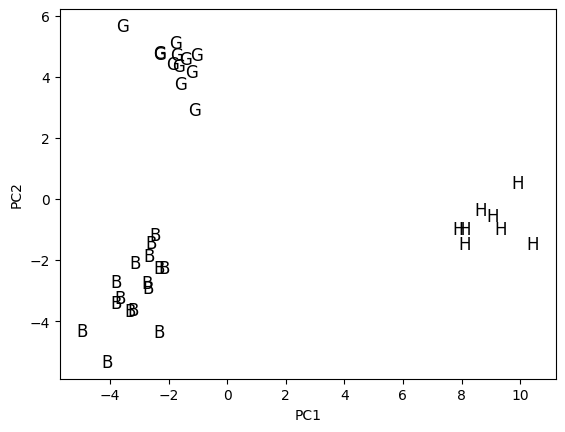

In [24]:
c1, c2 = documents_proj[:, 0], documents_proj[:, 1]

fig, ax = plt.subplots()
ax.scatter(c1, c2, facecolors='none')

for p1, p2, author in zip(c1, c2, authors):
    ax.text(p1, p2, author[0], fontsize=12,
            ha='center', va='center')

ax.set(xlabel='PC1', ylabel='PC2');

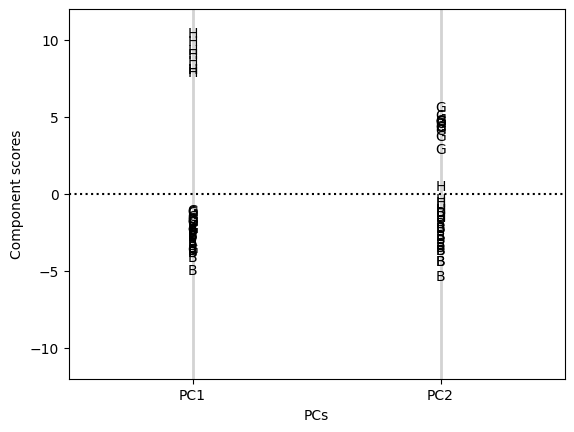

In [25]:
fig, ax = plt.subplots()

for idx in range(pca.components_.shape[0]):
    ax.axvline(idx, linewidth=2, color='lightgrey')
    for score, author in zip(documents_proj[:, idx], authors):
        ax.text(
            idx, score, author[0], fontsize=10,
            va='center', ha='center')

ax.axhline(0, ls='dotted', c='black')
ax.set(
    xlim=(-0.5, 1.5), ylim=(-12, 12),
    xlabel='PCs', ylabel='Component scores',
    xticks=[0, 1], xticklabels=["PC1", "PC2"]);

In [26]:
pca = sklearn.decomposition.PCA(n_components=2)
pca.fit(v_documents)

print(pca.components_.shape)

(2, 65)


In [27]:
pca = sklearn.decomposition.PCA(n_components=36)
pca.fit(v_documents)

print(len(pca.explained_variance_ratio_))

36


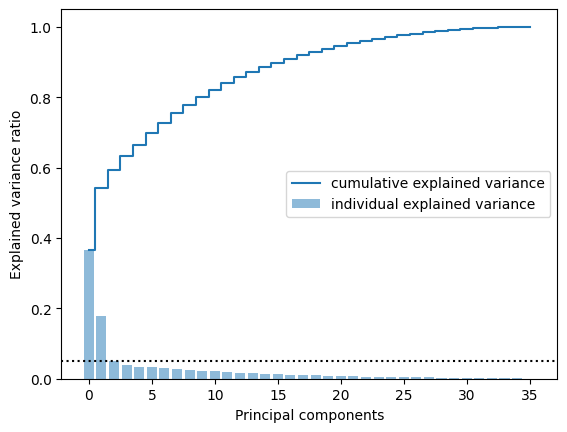

In [28]:
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

fig, ax = plt.subplots()

ax.bar(range(36), var_exp, alpha=0.5, align='center',
        label='individual explained variance')

ax.step(range(36), cum_var_exp, where='mid',
         label='cumulative explained variance')

ax.axhline(0.05, ls='dotted', color="black")
ax.set(ylabel='Explained variance ratio', xlabel='Principal components')
ax.legend(loc='best');

In [29]:
pca = sklearn.decomposition.PCA(n_components=2).fit(v_documents)
print(pca.components_)

[[-0.01261718 -0.17502663  0.19371289 -0.12537732  0.09937938  0.04919897
   0.04228911 -0.15115227 -0.15195474 -0.10807763  0.11127302  0.06461784
   0.02311066 -0.15508657  0.18115807  0.13316797 -0.10023716 -0.15724614
  -0.14267582 -0.15310695 -0.1639698   0.14963172  0.01974268 -0.01993491
   0.16352369  0.16325638  0.18241992 -0.01876223  0.01353673  0.14355216
   0.14360656 -0.17037739  0.03444619 -0.01124675  0.15083036 -0.16589861
   0.16872213  0.1762195  -0.14980888 -0.15457295  0.14496941  0.02299975
  -0.07249334 -0.14646948  0.02433003  0.1718574   0.11874338  0.00530384
  -0.09339339  0.03030971  0.09431566 -0.10360864 -0.14567335 -0.12521574
  -0.16743388 -0.06161694 -0.14897267  0.0139471   0.18018883 -0.00632689
  -0.03736204 -0.1113893  -0.05284575  0.15797111 -0.14855212]
 [ 0.25962781  0.0071369   0.05184334 -0.20380048  0.1408666  -0.16488909
  -0.17672985  0.04854289 -0.09200702  0.18644471  0.02623559 -0.24508709
  -0.05758209 -0.16455691  0.0346835  -0.11155652

In [30]:
X_centered = v_documents - np.mean(v_documents, axis=0)
X_bar1 = np.dot(X_centered, pca.components_.transpose())
X_bar2 = pca.transform(v_documents)

print(pca.components_.shape)
comps = pca.components_.transpose()
print(comps.shape)

(2, 65)
(65, 2)


In [31]:
import operator

vocab = vectorizer.get_feature_names_out()
vocab_weights = sorted(zip(vocab, comps[:, 0]), key=operator.itemgetter(1), reverse=True)
print('Positive loadings:')
print('\n'.join(f'{w} -> {s}' for w, s in vocab_weights[:5]))

print('Negative loadings:')
print('\n'.join(f'{w} -> {s}' for w, s in vocab_weights[-5:]))

Positive loadings:
in -> 0.19371288677377668
ita -> 0.18241992378624636
per -> 0.18115806688500907
uelut -> 0.18018882931856386
unde -> 0.17621949750358742
Negative loadings:
quam -> -0.16396980041076892
iam -> -0.16589861024232344
magis -> -0.16743388326578998
aut -> -0.17037738587759382
qui -> -0.17502663330844656


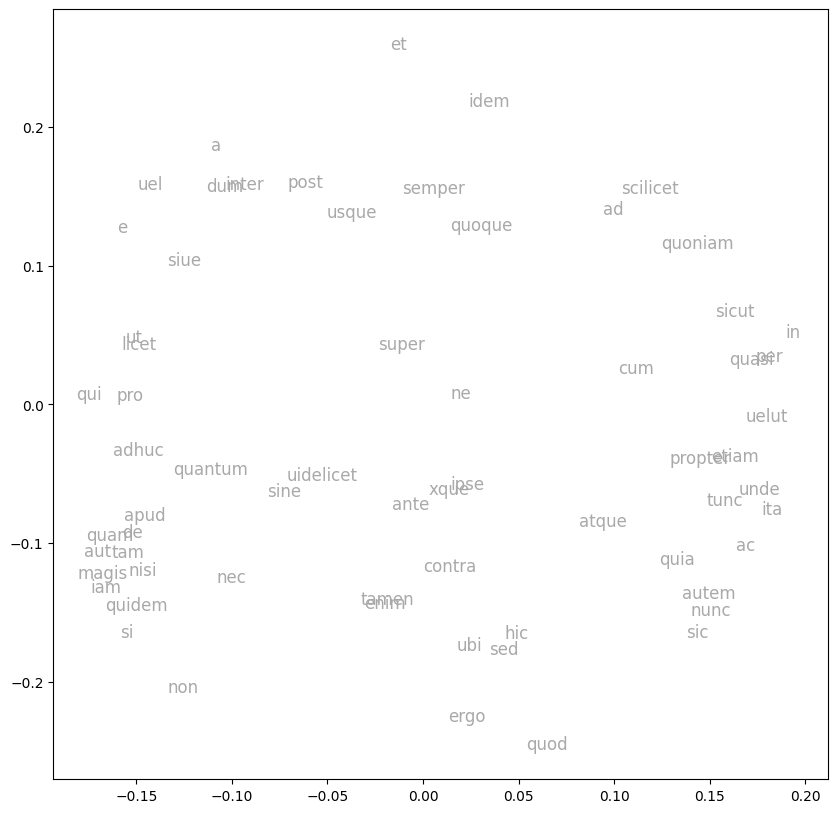

In [32]:
l1, l2 = comps[:, 0], comps[:, 1]

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(l1, l2, facecolors='none')

for x, y, l in zip(l1, l2, vocab):
    ax.text(x, y, l, ha='center', va='center', color='darkgrey', fontsize=12)

In [34]:
!pip install mpl_axes_aligner

  Preparing metadata (setup.py) ... done
  Created wheel for mpl_axes_aligner: filename=mpl_axes_aligner-1.3-py3-none-any.whl size=4754 sha256=236e592aba24b087af5cee42ee95d4186265043b26b55e5ce903cbc64f57f0fc
  Stored in directory: /root/.cache/pip/wheels/7d/57/ec/c27bcb29ff0f39ee5a71ed59474a92503b2a0112f4a283429b
Successfully built mpl_axes_aligner


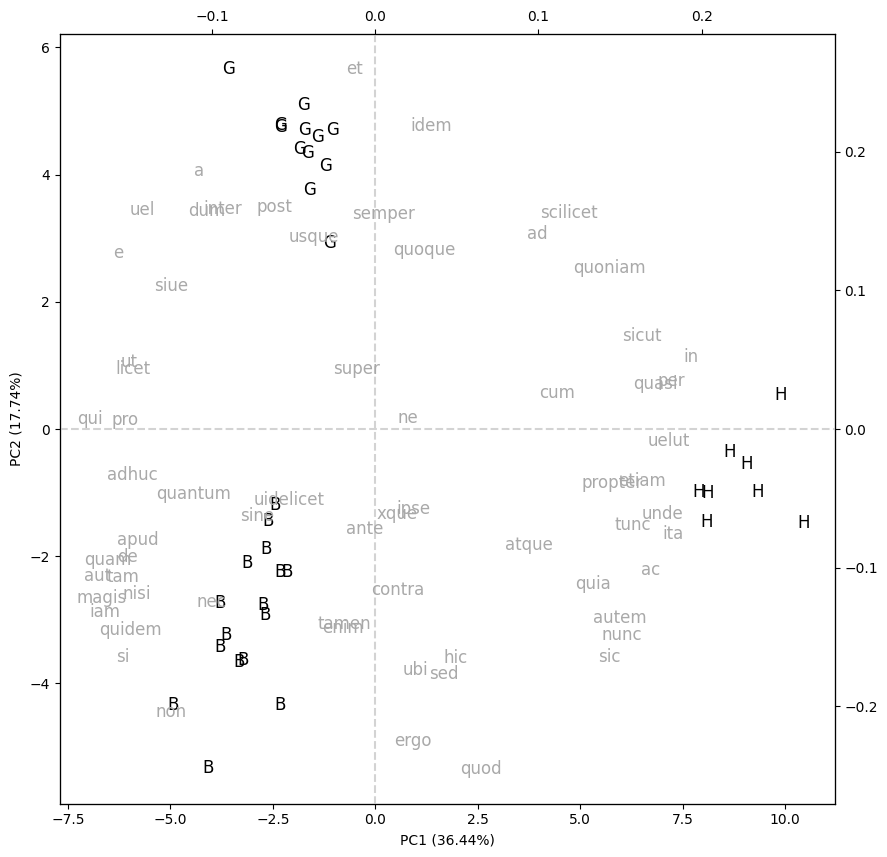

In [36]:
import mpl_axes_aligner.align

def plot_pca(document_proj, loadings, var_exp, labels):
    # first the texts:
    fig, text_ax = plt.subplots(figsize=(10, 10))
    x1, x2 = documents_proj[:, 0], documents_proj[:, 1]
    text_ax.scatter(x1, x2, facecolors='none')
    for p1, p2, author in zip(x1, x2, labels):
        color = 'red' if author not in ('H', 'G', 'B') else 'black'
        text_ax.text(p1, p2, author, ha='center',
                     color=color, va='center', fontsize=12)

    # add variance information to the axis labels:
    text_ax.set_xlabel(f'PC1 ({var_exp[0] * 100:.2f}%)')
    text_ax.set_ylabel(f'PC2 ({var_exp[1] * 100:.2f}%)')

    # now the loadings:
    loadings_ax = text_ax.twinx().twiny()
    l1, l2 = loadings[:, 0], loadings[:, 1]
    loadings_ax.scatter(l1, l2, facecolors='none');
    for x, y, loading in zip(l1, l2, vectorizer.get_feature_names_out()):
        loadings_ax.text(x, y, loading, ha='center', va='center',
                         color='darkgrey', fontsize=12)

    mpl_axes_aligner.align.yaxes(text_ax, 0, loadings_ax, 0)
    mpl_axes_aligner.align.xaxes(text_ax, 0, loadings_ax, 0)
    # add lines through origins:
    plt.axvline(0, ls='dashed', c='lightgrey', zorder=0)
    plt.axhline(0, ls='dashed', c='lightgrey', zorder=0);

# fit the pca:
pca = sklearn.decomposition.PCA(n_components=2)
documents_proj = pca.fit_transform(v_documents)
loadings = pca.components_.transpose()
var_exp = pca.explained_variance_ratio_

plot_pca(documents_proj, loadings, var_exp, authors)

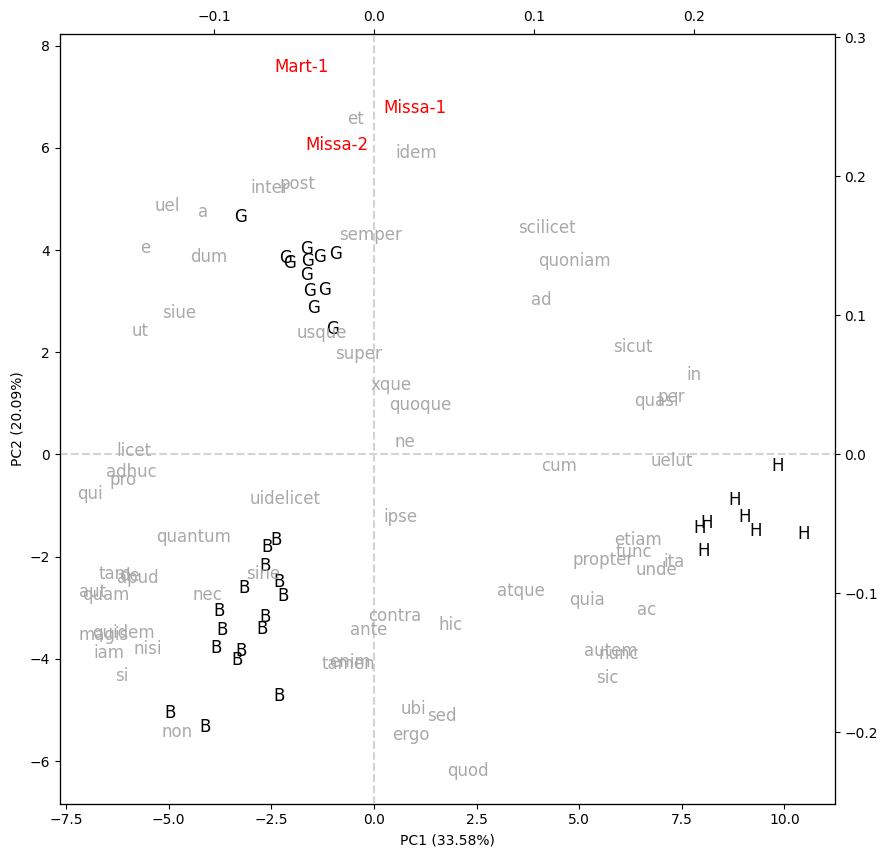

In [37]:
all_documents = preprocessing.scale(np.vstack((v_documents, v_test_docs)))
pca = sklearn.decomposition.PCA(n_components=2)
documents_proj = pca.fit_transform(all_documents)
loadings = pca.components_.transpose()
var_exp = pca.explained_variance_ratio_

plot_pca(documents_proj, loadings, var_exp, list(authors) + test_titles[1:])

# Easy

In [38]:
import tarfile

tf = tarfile.open('caesar.tar.gz', 'r')
tf.extractall('data')

In [39]:
def load_caesar_directory(directory):
    texts, authors, titles = [], [], []
    directory = Path(directory)
    for filename in sorted(directory.iterdir()):
        if not filename.suffix == '.txt':
            continue
        author, title, _ = filename.stem.split("_")

        authors.append(author)
        titles.append(title)

        with filename.open() as f:
            texts.append(f.read())

    return texts, authors, titles

In [40]:
texts, authors, titles = load_caesar_directory('data/caesar/')
len(texts) # there are 107 texts in the corpus

107

In [41]:
vectorizer = text.CountVectorizer(max_features=10000, token_pattern=r"(?u)\b\w+\b")
v_texts = vectorizer.fit_transform(texts).toarray()

print(v_texts.shape)

(107, 10000)


In [42]:
v_texts = preprocessing.normalize(v_texts.astype(float), norm='l1')

# Moderate

In [43]:
# compute pairwise distances between all documents in the corpus

distances_l1 = scidist.pdist(v_texts, metric='cityblock') # have normalized by L1 norm so use it here to compute distance

Text(0.5, 1.0, 'Similaries using L1 Norm')

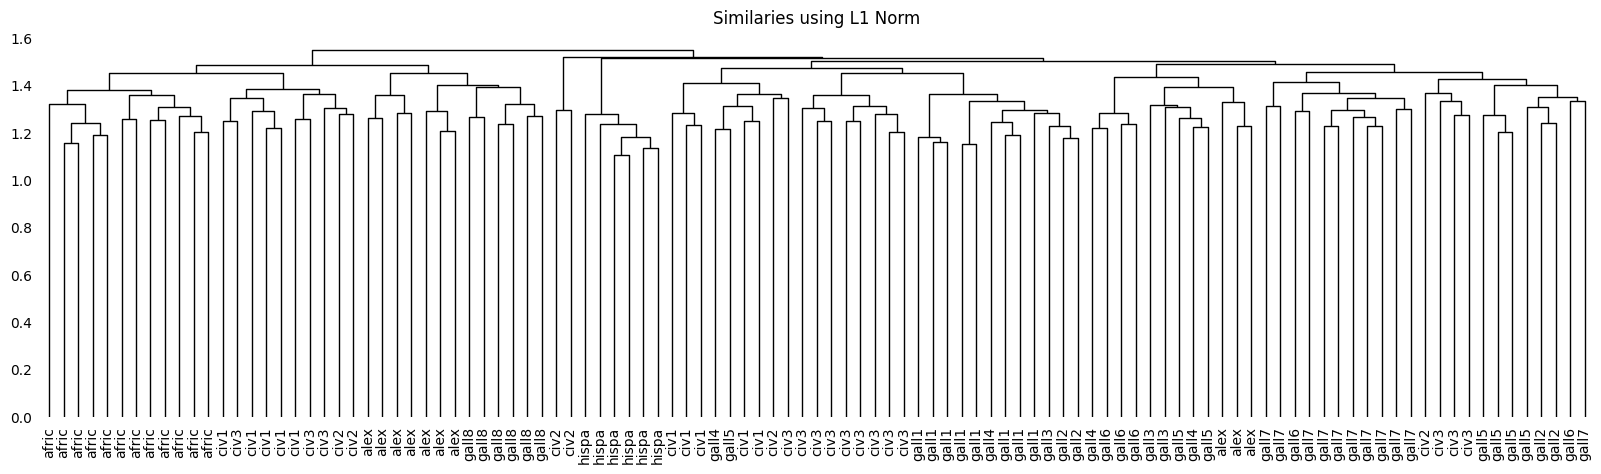

In [44]:
# Establish branch structure
linkage_object = hierarchy.linkage(distances_l1, method='complete')

# Visualize
def plot_tree(linkage_object, labels, figsize=(20, 5), ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    with plt.rc_context({'lines.linewidth': 1.0}):
        hierarchy.dendrogram(
            linkage_object, labels=labels, ax=ax,
            link_color_func=lambda c: 'black',
            leaf_font_size=10, leaf_rotation=90)
    # Remove ticks and spines
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    for s in ax.spines.values():
        s.set_visible(False)

plot_tree(linkage_object, titles)
plt.title('Similaries using L1 Norm')

The Alexandrian War text seems to be most similar to Hirtius's book 8.

Text(0.5, 1.0, 'Similaries using Cosine Norm')

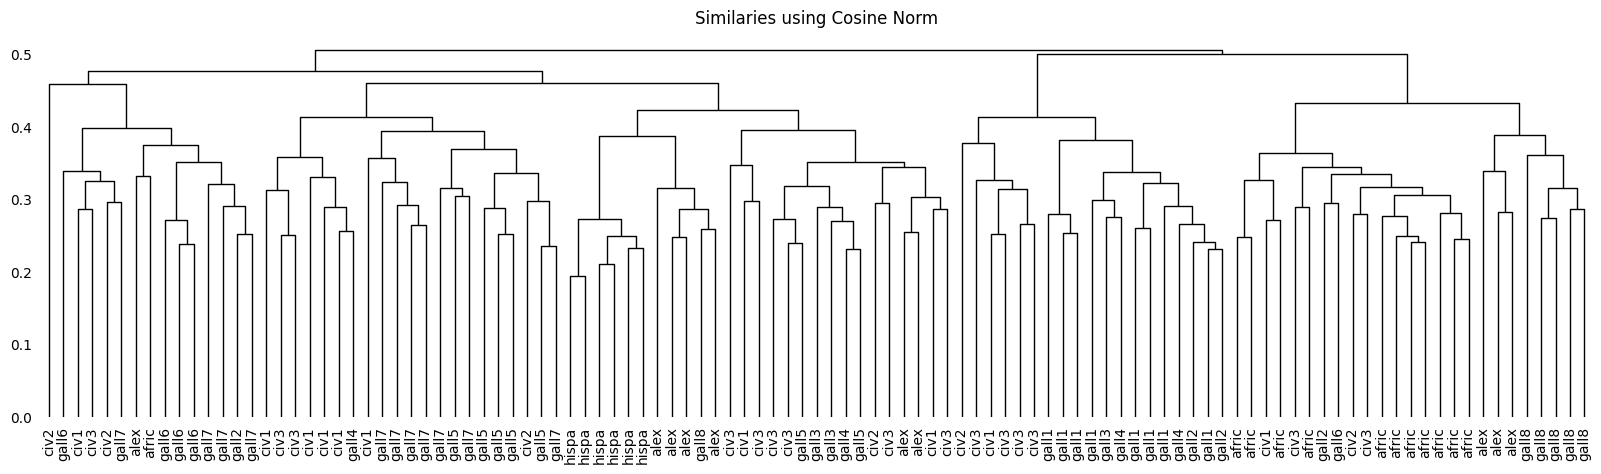

In [45]:
distances_cos = scidist.pdist(v_texts, metric='cosine')
linkage_object = hierarchy.linkage(distances_cos, method='complete')
plot_tree(linkage_object, titles)
plt.title('Similaries using Cosine Norm')

Text(0.5, 1.0, 'Similaries using Euclidean Distance')

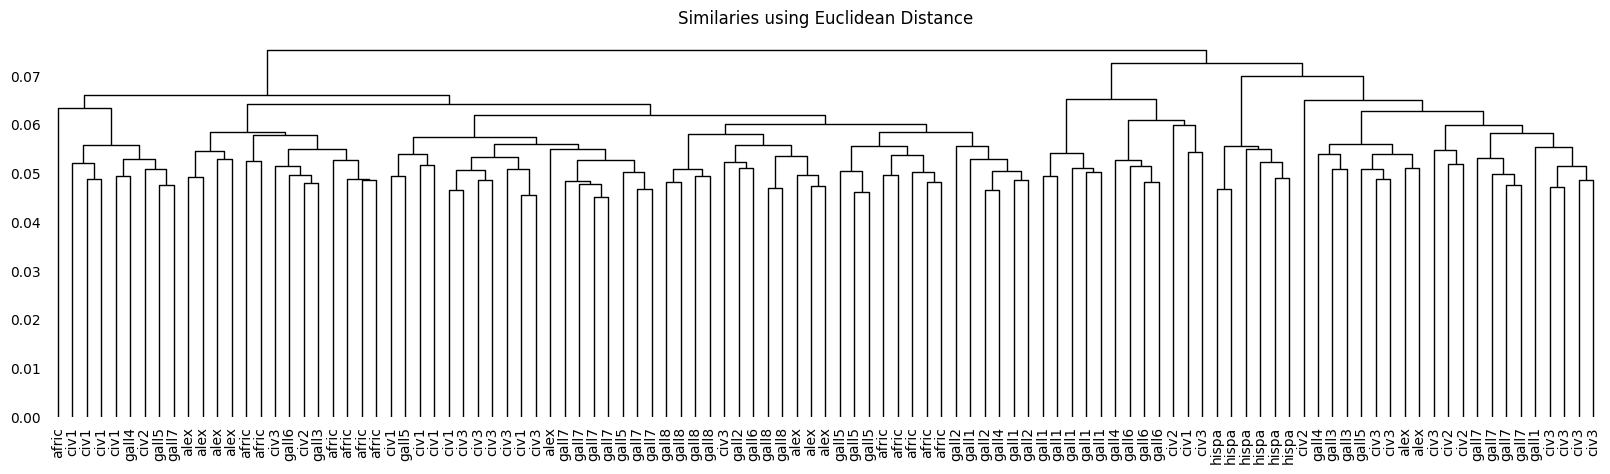

In [46]:
distances_eu = scidist.pdist(v_texts, metric='euclidean')
linkage_object = hierarchy.linkage(distances_eu, method='complete')
plot_tree(linkage_object, titles)
plt.title('Similaries using Euclidean Distance')

Text(0.5, 1.0, 'Similaries using Hamming Distance')

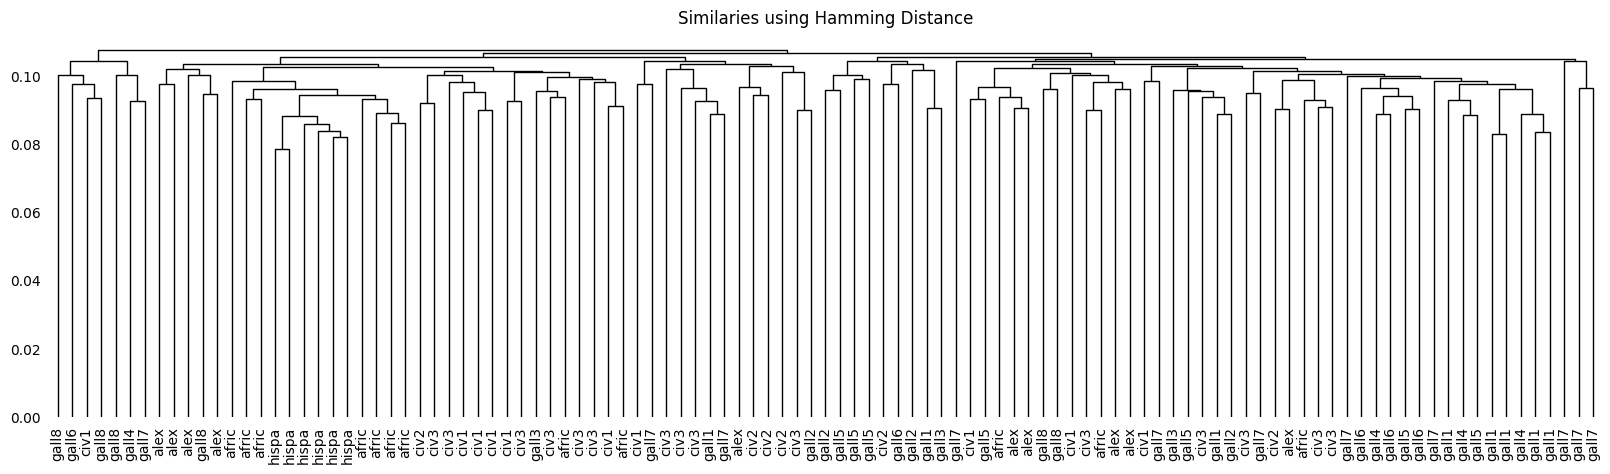

In [47]:
distances_ham = scidist.pdist(v_texts, metric='hamming')
linkage_object = hierarchy.linkage(distances_ham, method='complete')
plot_tree(linkage_object, titles)
plt.title('Similaries using Hamming Distance')

Of these norms, the Hamming distance is the least useful and noticeably scrambles the data more than the other norms. The Euclidean norm merges nodes of the shortest distance, and the L1 norm seems to split the Gallus 8 text most cleanly apart from the other texts. The other distance norms seem to also suggest that the Alexandrian War text is most similar to Gallus 8.

# Challenging

In [48]:
import tarfile

tf = tarfile.open('jack_the_ripper.tar.gz', 'r')
tf.extractall('data')

In [49]:
def load_jack_directory(directory):
    texts, authors, titles = [], [], []
    directory = Path(directory)
    for filename in sorted(directory.iterdir()):
        if not filename.suffix == '.txt':
            continue
        author = filename.stem.split("_")[0]
        title = filename.stem.split("_")[1:]
        title = '_'.join(title)


        authors.append(author)
        titles.append(title)

        with filename.open() as f:
            texts.append(f.read())

    return texts, authors, titles

In [50]:
texts, authors, titles = load_jack_directory('data/jack_the_ripper/')

In [51]:
vectorizer = text.CountVectorizer(token_pattern=r"(?u)\b\w+\b",
                                  ngram_range=(2,2), # only use bigrams
                                  binary = True,
                                  max_df = 0.2)
v_texts = vectorizer.fit_transform(texts).toarray()
v_texts = sklearn.preprocessing.scale(v_texts, axis=1) # normalize by columns

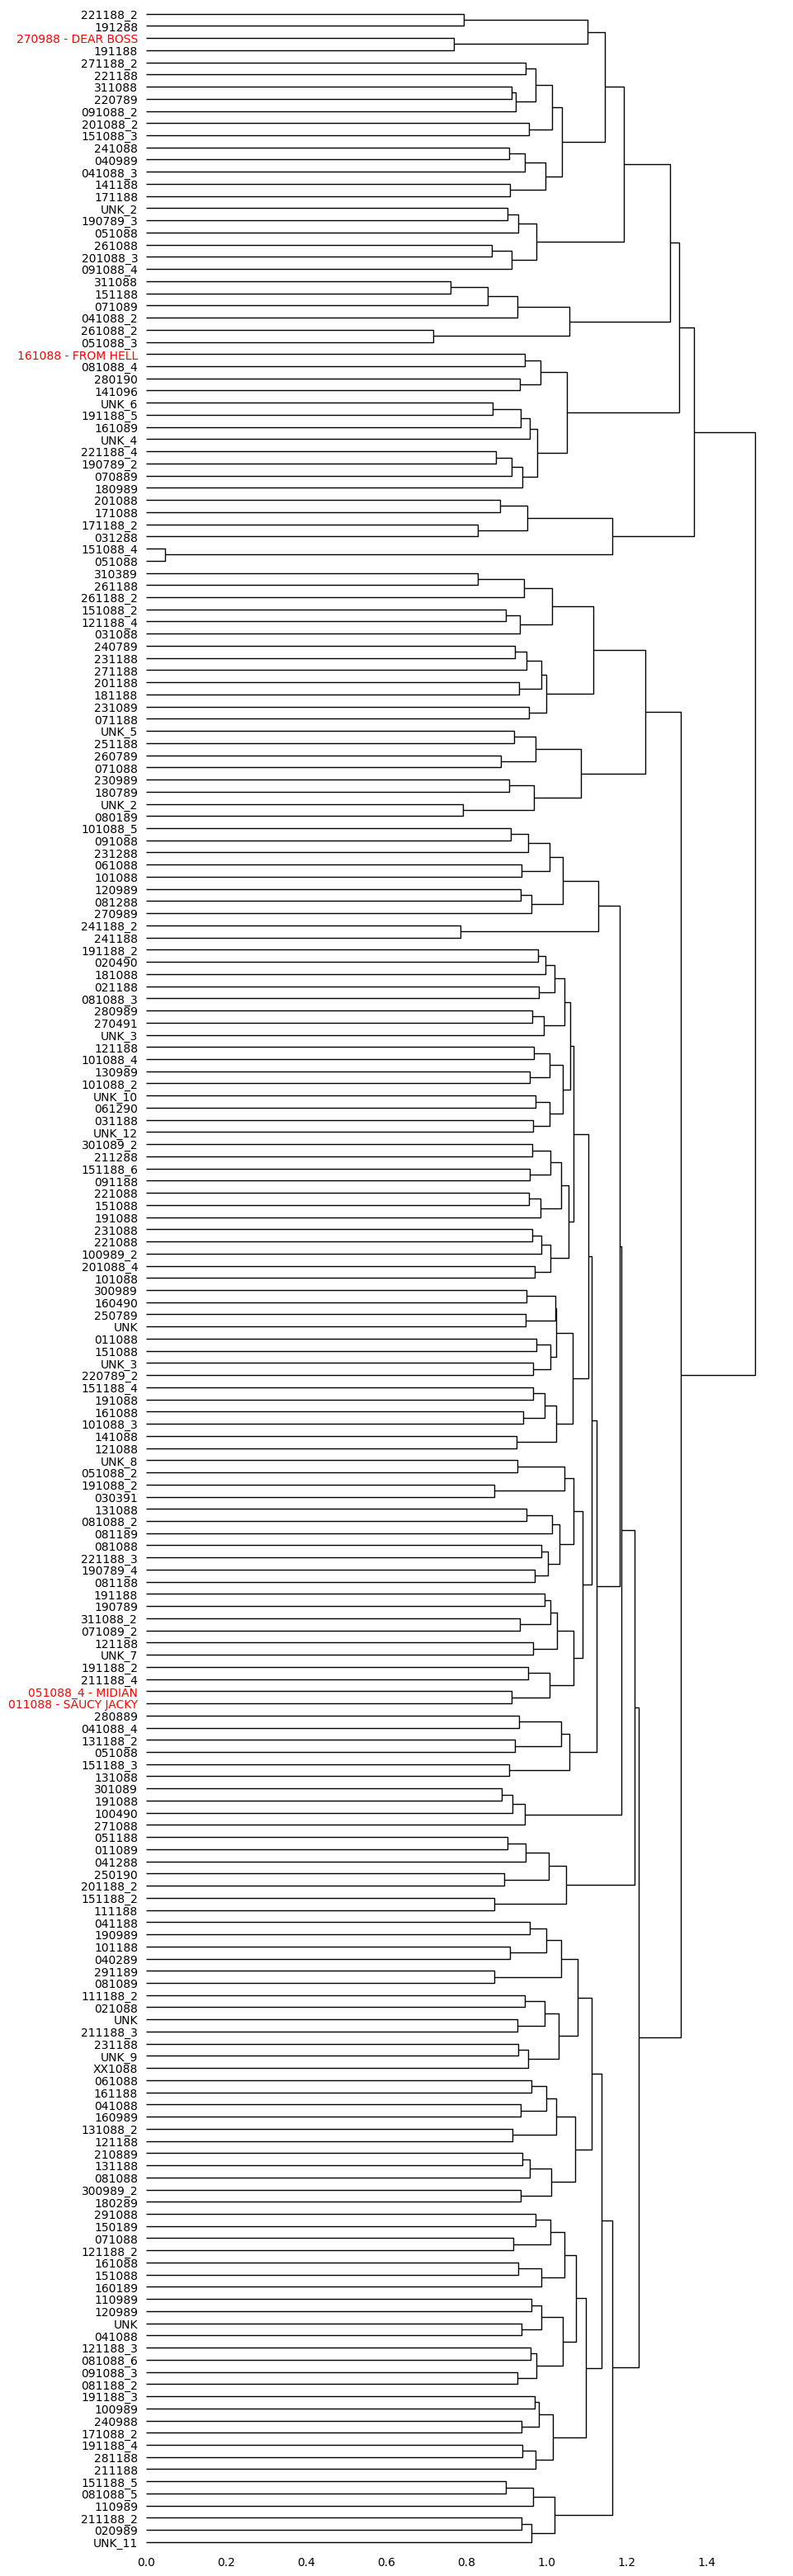

In [52]:
def plot_jack_tree(linkage_object, labels, figsize=(10, 40), ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    with plt.rc_context({'lines.linewidth': 1.0}):
      d = hierarchy.dendrogram(
              linkage_object, labels=labels, ax=ax,
              link_color_func=lambda x: 'black',
              leaf_font_size=10, leaf_rotation=0,
              orientation='right')

    # Remove ticks and spines
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    for s in ax.spines.values():
        s.set_visible(False)

    ylabels = ax.get_ymajorticklabels()
    for label in ylabels:
      if len(label.get_text()) > 8:
        label.set_color('red')

distances_cos = scidist.pdist(v_texts, metric='cosine')
linkage_object = hierarchy.linkage(distances_cos, method='ward')
plot_jack_tree(linkage_object, titles)

The Midian and Saucy Jacky texts are quite similar, which seems to indicate they could have been written by the same author, and supports Nini's conclusion.

In [152]:
def plot_pca(document_proj, loadings, var_exp, labels, titles):
    # first the texts:
    fig, text_ax = plt.subplots(figsize=(10, 10))
    x1, x2 = documents_proj[:, 0], documents_proj[:, 1]
    text_ax.scatter(x1, x2, facecolors='none')
    for p1, p2, author, title in zip(x1, x2, labels, titles):
        if len(title) > 8:
          color = 'red'
          title = title.split(" - ")[1]
          alpha = 1
        else:
          color = 'lightgrey'
          alpha = 0.5
        text_ax.text(p1, p2, title, ha='center',
                     color=color, va='center', fontsize=12, alpha = alpha)

    # add variance information to the axis labels:
    text_ax.set_xlabel(f'PC1 ({var_exp[0] * 100:.2f}%)')
    text_ax.set_ylabel(f'PC2 ({var_exp[1] * 100:.2f}%)')

    # now the loadings:
    loadings_ax = text_ax.twinx().twiny()
    l1, l2 = loadings[:, 0], loadings[:, 1]
    abs = np.absolute(np.multiply(l1,l2))

    max10 = sorted(abs)[-10:]
    max_indices = [np.where(abs == i)[0][0] for i in max10]

    loadings_ax.scatter(l1, l2, facecolors='none');
    for x, y, loading in zip(np.take(l1, max_indices), np.take(l2, max_indices), np.take(vectorizer.get_feature_names_out(), max_indices)):
        loadings_ax.text(x, y, loading, ha='center', va='center',
                         color='black', fontsize=12)

    mpl_axes_aligner.align.yaxes(text_ax, 0, loadings_ax, 0)
    mpl_axes_aligner.align.xaxes(text_ax, 0, loadings_ax, 0)
    # add lines through origins:
    plt.axvline(0, ls='dashed', c='lightgrey', zorder=0)
    plt.axhline(0, ls='dashed', c='lightgrey', zorder=0);

In [135]:
pca = sklearn.decomposition.PCA(n_components=2)
documents_proj = pca.fit_transform(v_texts)
loadings = pca.components_.transpose()
var_exp = pca.explained_variance_ratio_

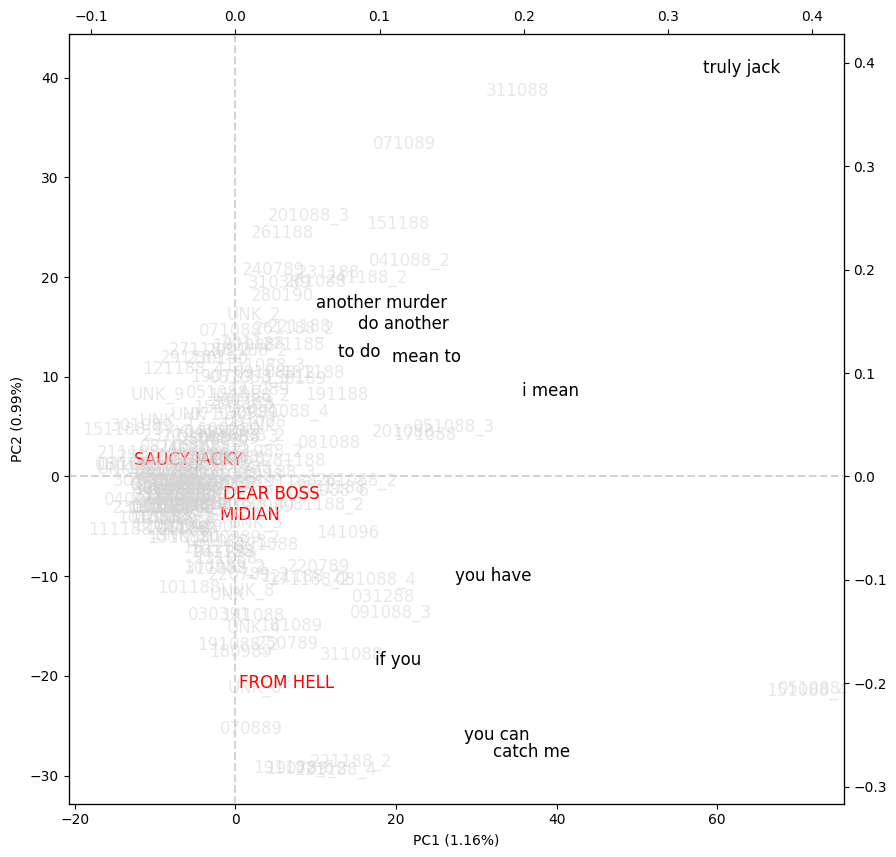

In [153]:
plot_pca(documents_proj, loadings, var_exp, authors, titles)

The "From Hell" prepublication seems to be significantly different from the other three letters, which suggests it may have been written by a different author. This letter uses the bigrams 'you can', 'if you', 'you have', and 'catch me' more often than the others. It talks less about the murder and more about the process of apprehending the killer, which suggests a different author than Jack the Ripper wanting to taunt the police.